In [54]:
import os
current_directory = os.getcwd()
print(f"Current Working Directory: {current_directory}")

from Tusc5ImageUtils import *
import numpy as np
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
from skimage import exposure
mpl.rcParams['figure.dpi'] = 200
from cellpose import utils, io, plot, models, denoise
from scipy.ndimage import binary_erosion, binary_dilation, binary_fill_holes, center_of_mass
import subprocess
import pandas as pd
import nd2
from skimage.measure import regionprops

import tkinter as tk
from tkinter.ttk import *
from PIL import Image, ImageTk, ImageEnhance
import numpy as np

Current Working Directory: /Users/raphaeltinio/Lab Analysis MAC/ImageAnalysis


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


(-0.5, 10.5, 10.5, -0.5)

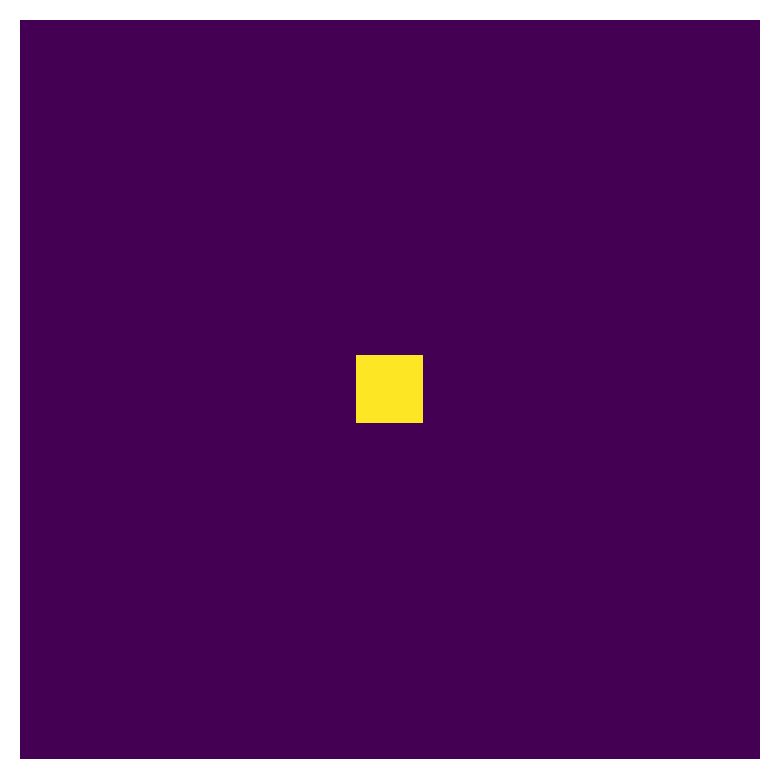

In [55]:
template = np.zeros((11,11))
template[5,5] = 1
print(template)
plt.imshow(template)
plt.axis('off')

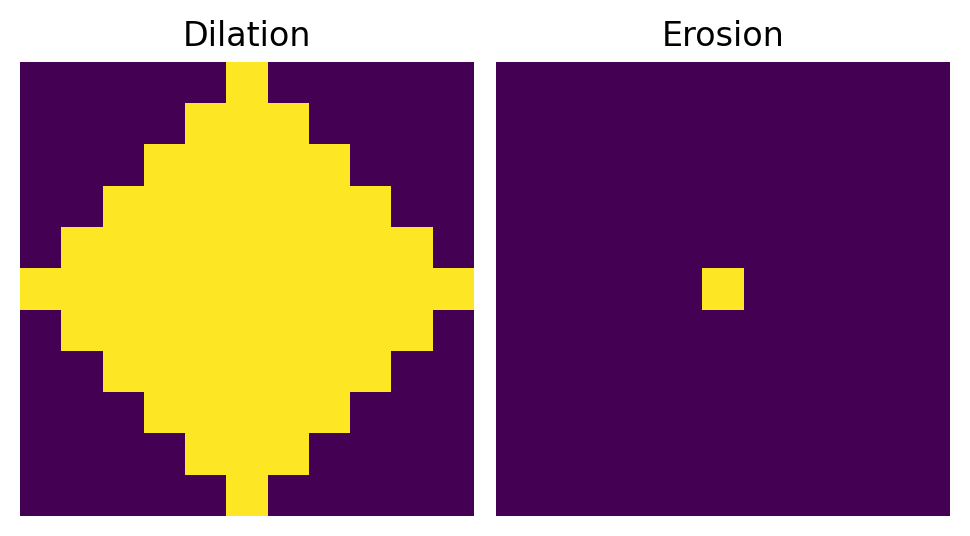

In [56]:
dilation = binary_dilation(template, iterations = 5).astype(int)
erosion = binary_erosion(dilation, iterations = 5).astype(int)

caps = ['Dilation', 'Erosion']
plot_2images(dilation, erosion, titles= caps)

In [57]:
dilation_5 = binary_dilation(template, iterations = 5).astype(int)

dilation_2 = binary_dilation(template, iterations = 2).astype(int)

array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
       [0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0],
       [0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

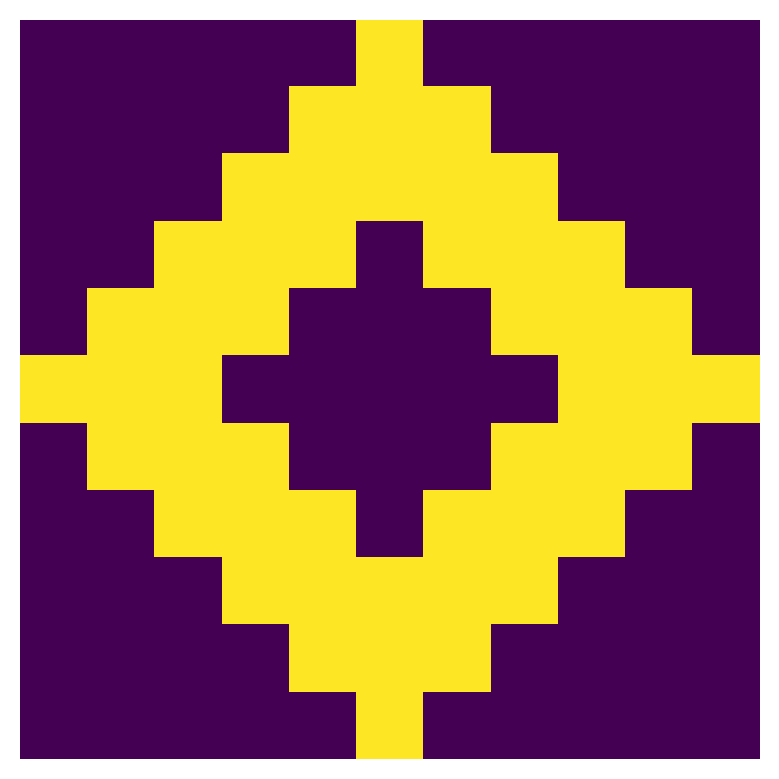

In [58]:
plt.imshow(dilation_5 - dilation_2)
plt.axis('off')
dilation_5 - dilation_2


# On Real Data

In [64]:
def upload_training_cells(DAPI_stack, WGA_stack, single_mask, extra_space=50):
    sq_maski = square_mask(single_mask)

    _, _, comzi = nucleus_com(DAPI_stack, single_mask)  # Gets the nucleus stack of the middle of the cell

    # Calculate the bounding box of the square mask
    min_row, min_col, max_row, max_col = regionprops(sq_maski.astype(int))[0].bbox

    # Dimensions of the region of interest
    roi_height = max_row - min_row
    roi_width = max_col - min_col

    # Dimensions of the new canvas with extra space
    new_height = roi_height + 2 * extra_space
    new_width = roi_width + 2 * extra_space

    # Create new black canvas (filled with zeros)
    new_WGA_slice = np.zeros((new_height, new_width), dtype=WGA_stack.dtype)
    new_DAPI_slice = np.zeros((new_height, new_width), dtype=DAPI_stack.dtype)

    # Calculate the placement of the ROI in the new canvas
    new_min_row = extra_space
    new_min_col = extra_space

    # Extract the region of interest and place it in the center of the new canvas
    sq_WGA_slice = WGA_stack[comzi, min_row:max_row, min_col:max_col]
    new_WGA_slice[new_min_row:new_min_row + roi_height, new_min_col:new_min_col + roi_width] = sq_WGA_slice
    
    sq_DAPI_stack = DAPI_stack[comzi, min_row:max_row, min_col:max_col]
    sq_DAPI_slice = sq_DAPI_stack
    new_DAPI_slice[new_min_row:new_min_row + roi_height, new_min_col:new_min_col + roi_width] = sq_DAPI_slice

    return new_WGA_slice, new_DAPI_slice


In [61]:
### Directory Configuration ###

parent_directory = os.path.dirname(current_directory) # Parent directory
one_stack_dir = os.path.join(parent_directory, 'one stack')

model_path_dapi = os.path.join(parent_directory, 'ImageAnalysis/cellpose_models/T5_DAPI_V4')
model_V2 = os.path.join(parent_directory, 'ImageAnalysis/cellpose_models/T5_WGA_V2')
img_path = os.path.join(one_stack_dir, '3203R_GLUT1_647_WGA_594_0002.nd2')

In [60]:
### Image Insertion ###

f = nd2.ND2File(img_path)
image = to_8bit(f.asarray())

DAPI_stack = image[:,0,:,:].copy()
eGFP_stack = image[:,1,:,:].copy()
WGA_stack = image[:,2,:,:].copy()
GLUT1_stack = image[:,3,:,:].copy()

mp_DAPI = max_proj(DAPI_stack)
deblur_model = denoise.CellposeDenoiseModel(gpu=True, model_type=model_path_dapi, restore_type="T5_DAPI_V4")
DAPI_masks, flows, styles, image_deblurred = deblur_model.eval(auto_brightness_contrast(mp_DAPI), diameter=None, channels=[0, 0])
image_deblurred = image_deblurred[:, :, 0]  # resulting image has one channel, but it still needs to be indexed

Diameter: 73.92563831310488


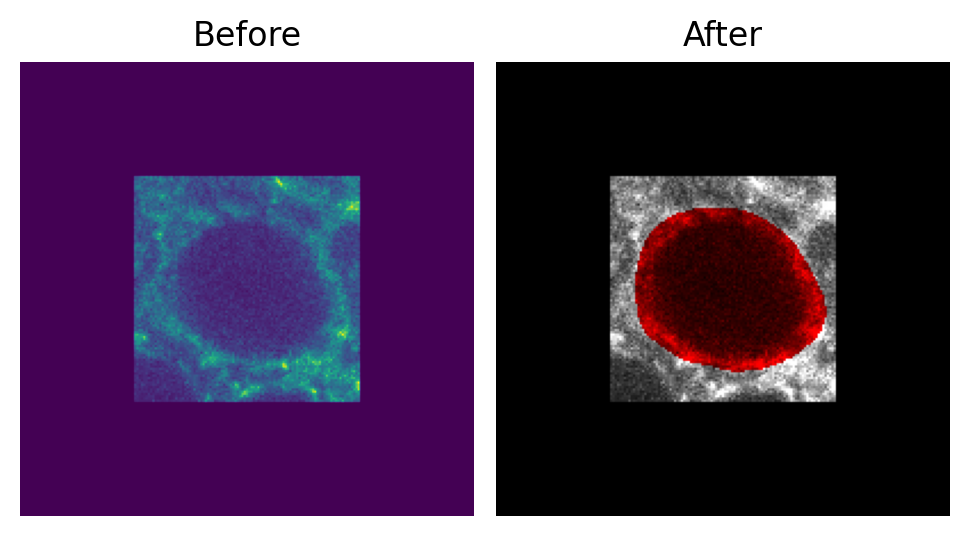

In [125]:
def quickview_channels_model(mask_id):
    global DAPI_stack
    global DAPI_masks
    global WGA_stack

    extracted_mask = extract_masks(DAPI_masks, mask_id)
    diam = get_mask_diameter(extracted_mask)
    print('Diameter:', diam)

    sq_WGA_slice, sq_DAPI_slice = upload_training_cells(DAPI_stack, WGA_stack, extracted_mask)

    stack_image = np.stack((sq_WGA_slice, sq_DAPI_slice))

    ###
    model = models.CellposeModel(gpu = True, pretrained_model=model_V2)
    masks1, flows, styles = model.eval(auto_brightness_contrast(sq_WGA_slice), diameter=diam, channels=[0,0])

    overlay = plot.mask_overlay(auto_brightness_contrast(sq_WGA_slice), masks1)

    # Visualization help
    #overlay = remove_boundary(overlay, pixels_to_remove = 50)
    #sq_WGA_slice = remove_boundary(sq_WGA_slice, pixels_to_remove = 50)

    plot_2images(sq_WGA_slice, overlay)

    return masks1, sq_WGA_slice


tmask, raw_img = quickview_channels_model(63)

In [114]:
delta = int(1 / f.voxel_size().x)

(-0.5, 98.5, 98.5, -0.5)

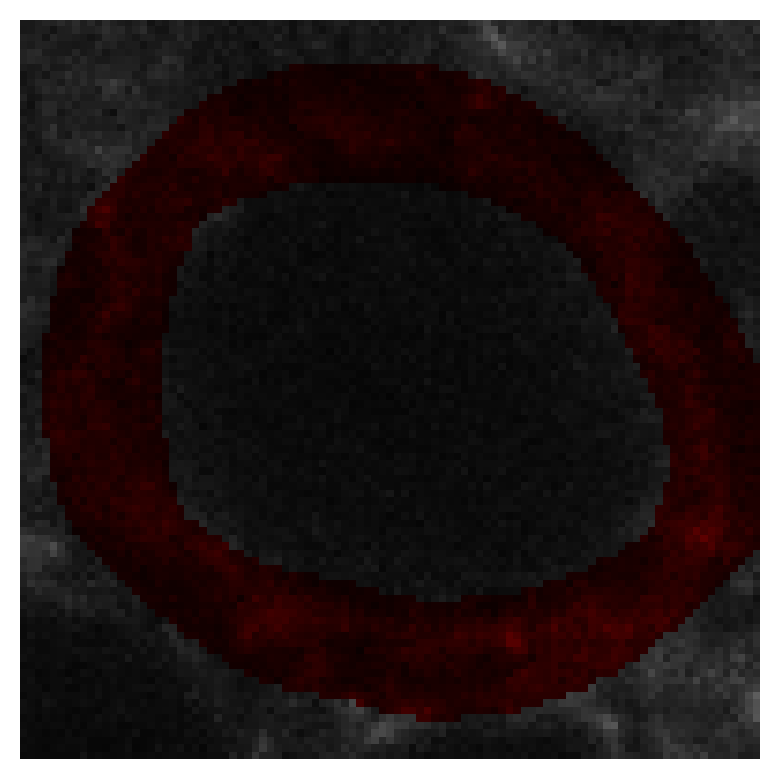

In [132]:
#raw_img = remove_pixels_from_edges(raw_img, 50)

tmask = remove_boundary(tmask, 50)

dil_mask = binary_dilation(tmask, iterations = delta).astype(int)
ero_mask = binary_erosion(tmask, iterations = delta).astype(int)
sur_mask = dil_mask - ero_mask

overlay = plot.mask_overlay(raw_img, sur_mask)
plt.imshow(overlay)
plt.axis('off')

In [159]:
sur_data = raw_img[sur_mask.astype(bool)]

print('length of array:', len(sur_data))
std_2 = np.std(sur_data)*2
print('2 standard deviations:', std_2)
mean = np.mean(sur_data)


length of array: 3517
2 standard deviations: 14.41073424594563


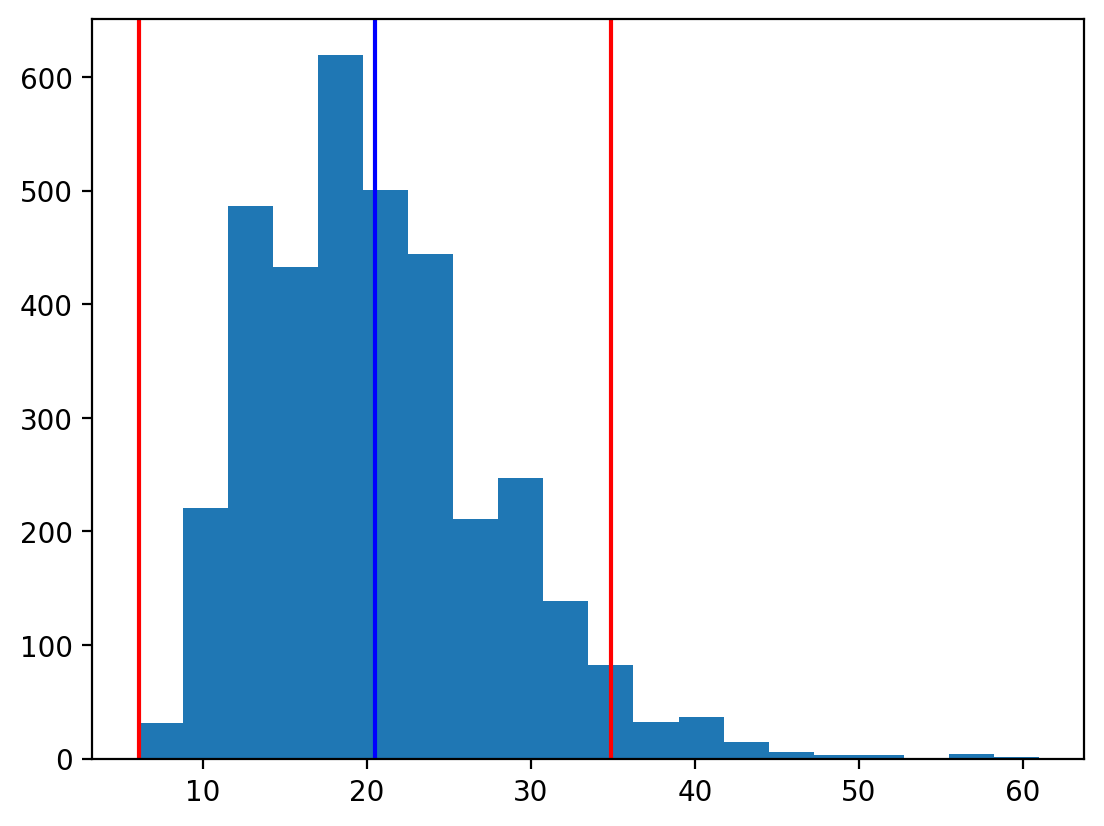

In [160]:
plt.hist(sur_data, bins = 20)
plt.axvline(x = std_2 + mean, color = 'r')
plt.axvline(x = -std_2 + mean, color = 'r')
plt.axvline(x = mean, color = 'b')

In [222]:
mask_vals = raw_img[sur_mask.astype(bool)]
lower_bound = -std_2 + mean
upper_bound = std_2 + mean

In [240]:
sur_mod = sur_mask.copy()

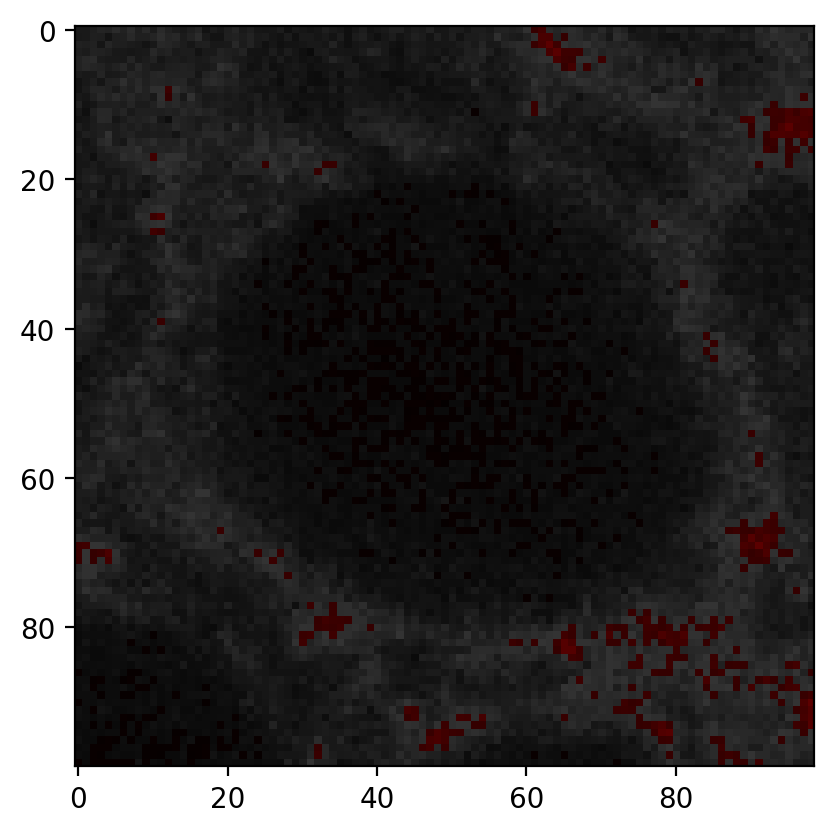

In [261]:
r_mask = (raw_img > upper_bound) | (raw_img < lower_bound)

plt.imshow(plot.mask_overlay(raw_img, r_mask.astype(int)))

# Different Kind of Mask

In [286]:
o_vals = raw_img[tmask.astype(bool)]
o_mean = np.mean(o_vals)
o_std2 = np.std(o_vals) * 2

o_low_bound = o_mean + o_std2
o_upper_bound = o_mean - o_std2

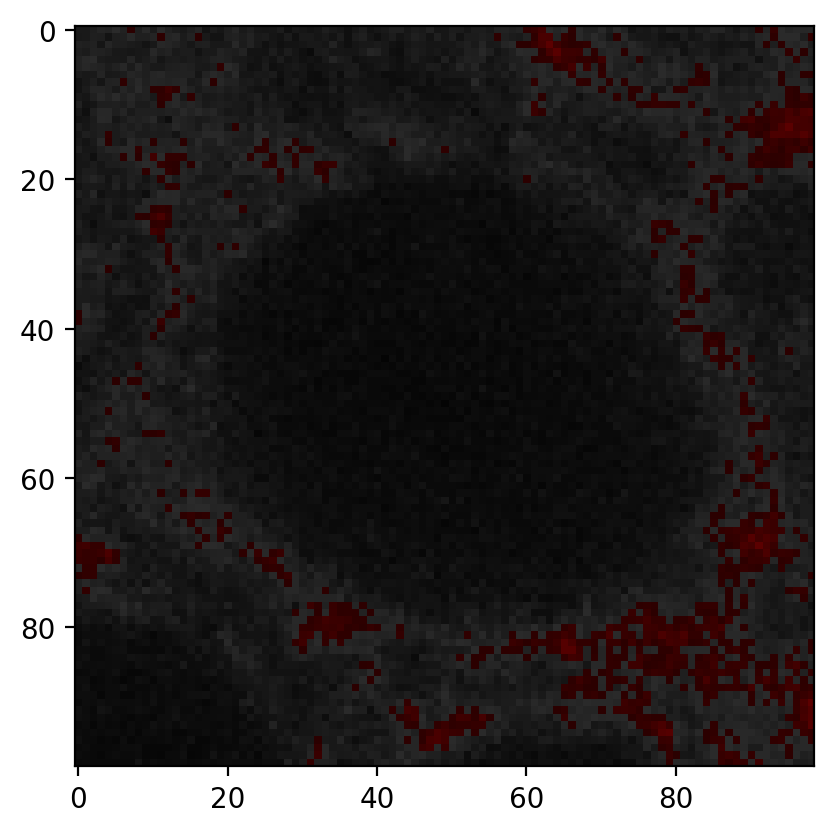

In [312]:
lpl = raw_img >= o_low_bound

plt.imshow(plot.mask_overlay(raw_img, lpl.astype(int)))

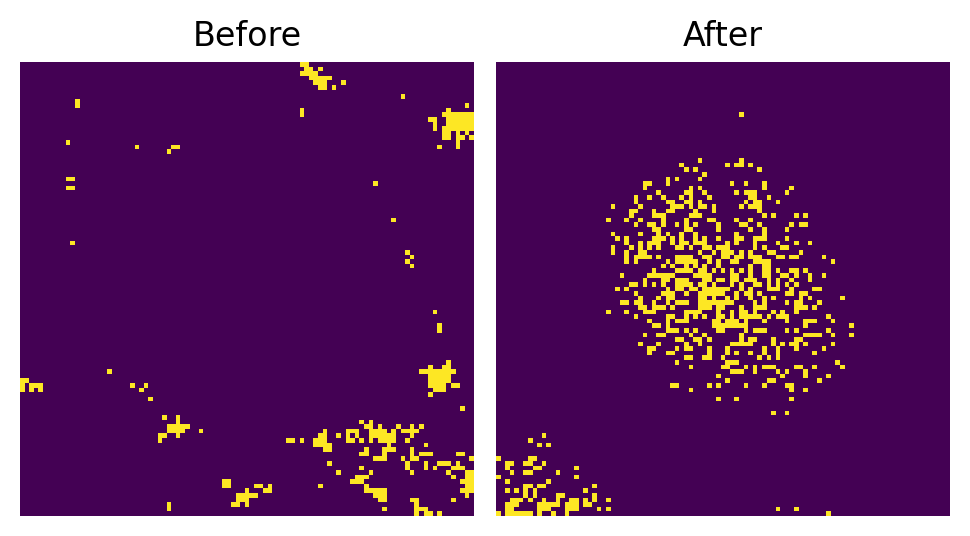

In [314]:
s_vals = raw_img[sur_mask.astype(bool)]
s_mean = np.mean(s_vals)
s_std2 = np.std(s_vals) * 2

s_low_bound = s_mean + s_std2
s_upper_bound = s_mean - s_std2

plot_2images((raw_img >= s_low_bound), (raw_img <= s_upper_bound))

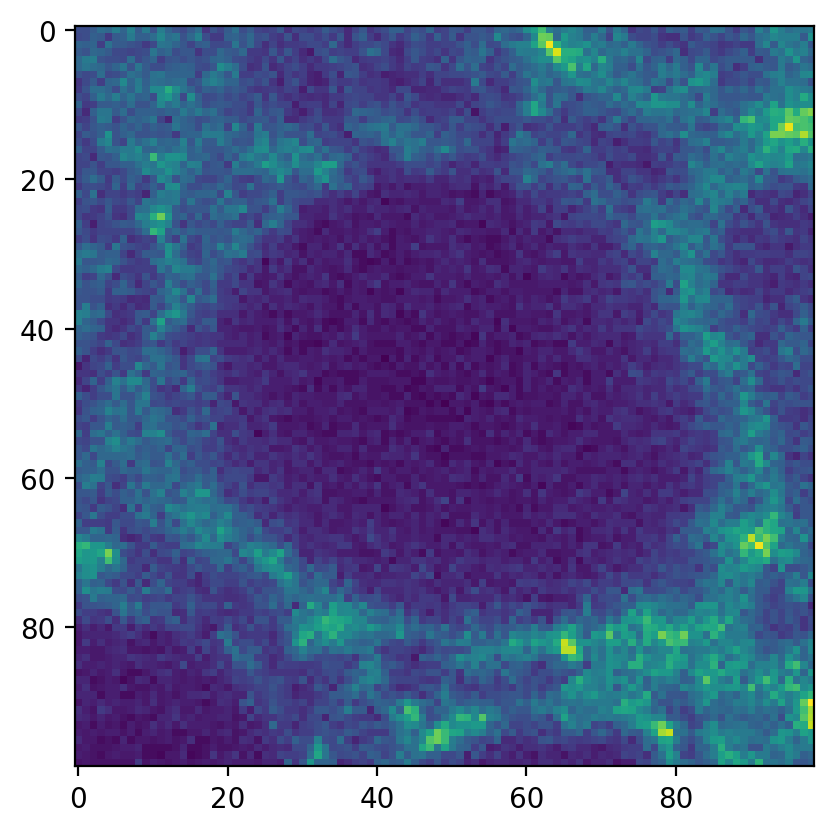

In [320]:
plt.imshow(raw_img)